In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import re 
pd.options.display.max_colwidth = 200
import gensim


## Recreate Final Model

In [3]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [4]:
nlp_emails= pd.read_csv('nlp_emails.csv')

In [7]:
nlp_emails[0:3]

,Unnamed: 0,text,spam,norm_X,nlp_X,topic
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1
2,1498,"Subject: merit and equity increases norma , i am sending you an excel spreadsheet with proposed merit and equity increases . i have slightly exceeded the merit quota . the equity increases ad...",0,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address two issues retention error setting salary...,subject merit equity increases norma sending excel spreadsheet proposed merit equity increases slightly exceeded merit quota equity increases address issues retention error setting salary hiring t...,3


In [10]:
nlp_X = np.array(nlp_emails['nlp_X'])

## Train the Naive Bayes Model

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features= 2500)
tv_nlp_X = tv.fit_transform(nlp_X)
tv_nlp_X = tv_nlp_X.toarray()

vocab = tv.get_feature_names()
#pd.DataFrame(np.round(tv_nlp_X, 2), columns=vocab)
len(vocab)

2500

In [12]:
nlp_emails[0:2]

,Unnamed: 0,text,spam,norm_X,nlp_X,topic
0,3973,"Subject: fyi : energy operations promotions hi vince , scott pleus ( listed below in the director promotion section ) is bandwidth - trading backoffice person we  , ve been working with . i hav...",0,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs since started around time fac...,subject fyi energy operations promotions hi vince scott pleus listed director promotion section bandwidth trading backoffice person  working known scott ebs started time fact people talk sally be...,4
1,4996,"Subject: hedge effectiveness test for fair value hedges gentlemen : we have had favorable responses regarding the use of our volatility reduction method ( roger , i ' ve attached a copy of our ...",0,subject hedge effectiveness test fair value hedges gentlemen favorable responses regarding use volatility reduction method roger attached copy article case seen however continued quibble ...,subject hedge effectiveness test fair value hedges gentlemen favorable responses use volatility reduction method roger attached copy article case seen continued quibble create set data points inpu...,1


In [14]:
y = np.array(nlp_emails['spam'])

### Split emails dataset into to train/ test se

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tv_nlp_X, y, test_size=0.33, random_state=42)

In [16]:
X_train_features=pd.DataFrame(np.round(X_train, 2),columns = vocab)

X_test_features=pd.DataFrame(np.round(X_test, 2), columns = vocab)

In [17]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train,y_train)

GaussianNB()

### Predict the Test set result

In [18]:

y_pred = clf.predict(X_test)
result=np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
result[0:10]

array([[0, 1],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 1]])

### Making the Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[239   4]
 [ 29  58]]


0.9

In [20]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       243
           1       0.94      0.67      0.78        87

    accuracy                           0.90       330
   macro avg       0.91      0.83      0.86       330
weighted avg       0.90      0.90      0.89       330



### GradientBoostingRegressor Model

In [21]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(X_train_features)

# Transform both training data and testing data
X = imputer.transform(X_train_features)
X_test = imputer.transform(X_test_features)


SimpleImputer(strategy='median')

In [22]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [23]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X_train, y_train)

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=800,
                          random_state=42)

In [24]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 0.1061


## Interprete the Model¶
Explore several ways to interpret our model: Feature importances Locally Interpretable Model-agnostic Explainer (LIME) Examining a single decision tree in the ensemble.

### Feature Importances

In [25]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,vince,0.495711
1,enron,0.276709
2,research,0.093886
3,attached,0.074133
4,meeting,0.058995
5,subject,0.000566
6,ability,0.000000
7,pleased,0.000000
8,platform,0.000000
9,platforms,0.000000


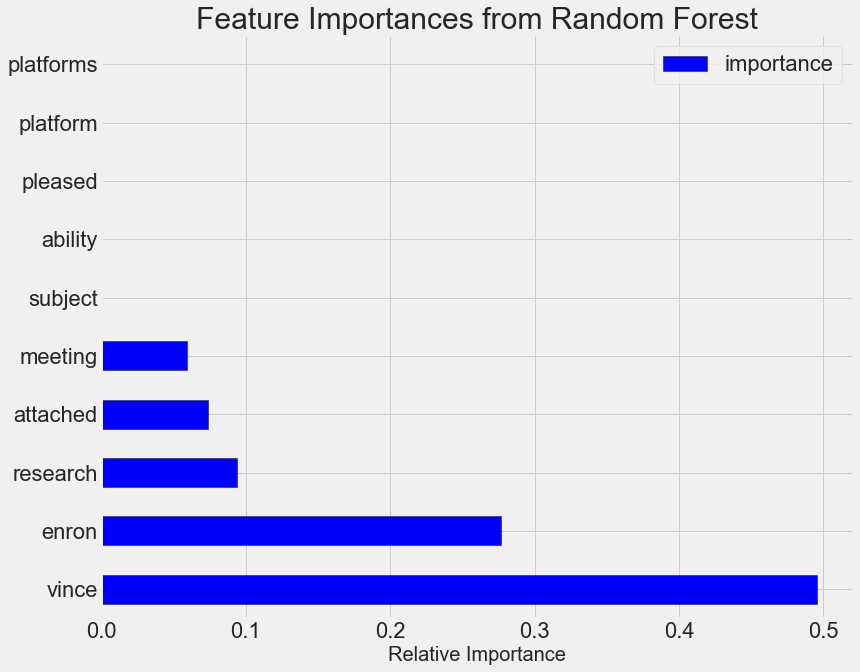

In [26]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

### Use Feature Importances for Feature Selection¶

In [27]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(X_train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (670, 10)
Most important testing  features shape:  (330, 10)


In [28]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X_train, y_train)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y_train)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))


LinearRegression()

LinearRegression()

Linear Regression Full Results: MAE =    0.1507.
Linear Regression Reduced Results: MAE = 0.3235.


In [29]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=800,
                          random_state=42)

Gradient Boosted Reduced Results: MAE = 0.1061


### Locally Interpretable Model-agnostic Explanations (LIME)

In [30]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [31]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 0.0000
Actual Value: 1.0000


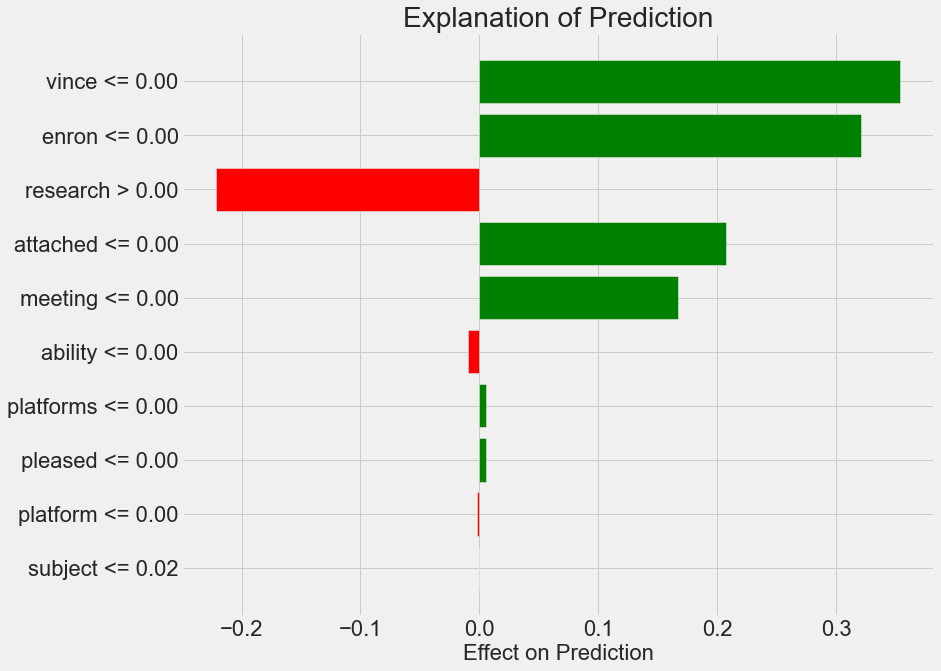

In [32]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [33]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 0.0000
Actual Value: 0.0000


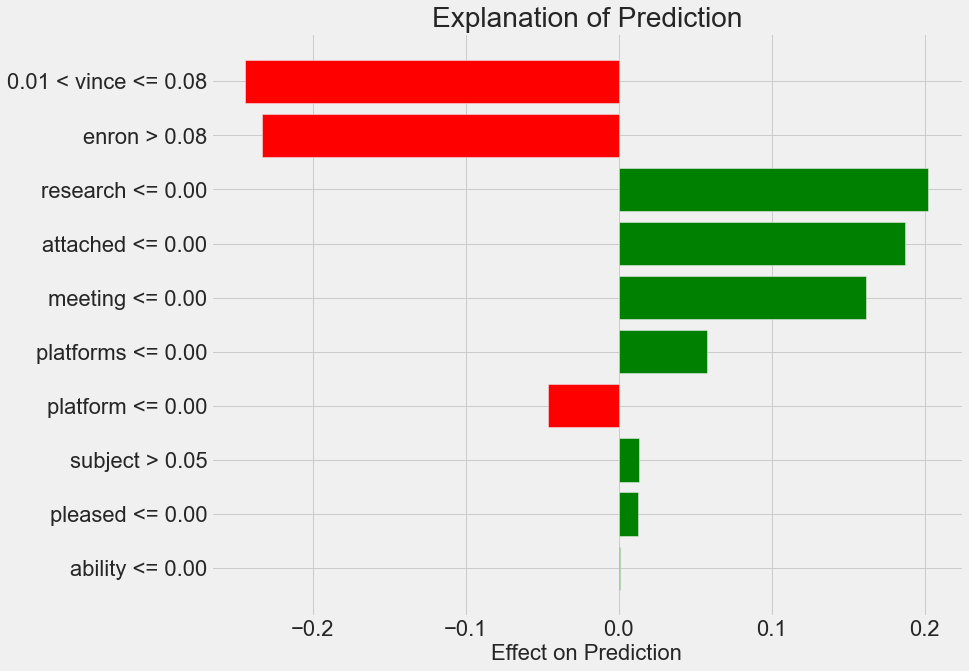

In [34]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

## Examining a Single Decision Tree

In [35]:
# Extract a single tree
from sklearn.tree import export_graphviz

single_tree = model_reduced.estimators_[105][0]


tree.export_graphviz(single_tree, out_file = 'images_tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=6,
                      min_samples_split=6,
                      random_state=RandomState(MT19937) at 0x7FA41E0A3C40)

In [36]:
tree.export_graphviz(single_tree, out_file = 'images_tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

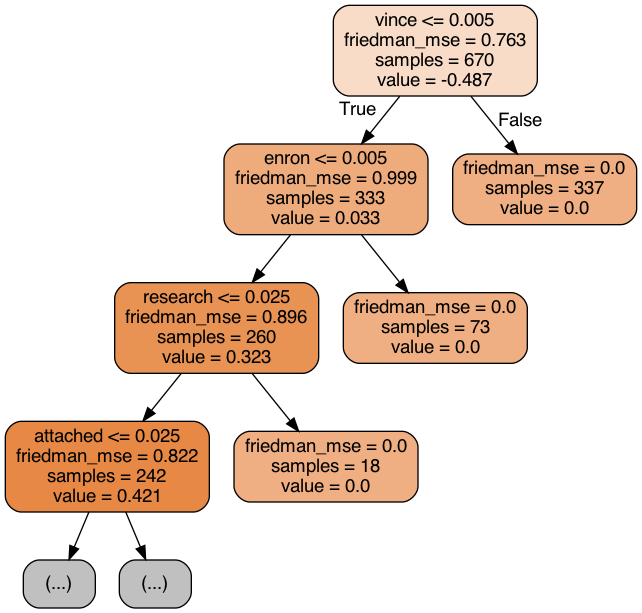

In [37]:
!dot -Tpng images_tree_small.dot -o images_tree_small.png
from IPython.display import Image
Image(filename = 'images_tree_small.png')